# Single Cell Sequencing 


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs data aggregation from all plates.<br>
Performs quality control.<br>
Performs filtering.<br>
Performs normalization.<br>
Exports pre-processed data to h5ad file for further analysis.<br>

In [1]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
import pyreadr
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.10.3 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
raw_data_path = general_paths.raw_data_path

In [3]:
# Filtering parameters

HOW_MANY_HIGHLY_VARIABLE_GENES = 16000 # it used to be 15000 (but that cuts out Piezo1 after filtering out not highly variable genes)
MIN_CELL_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS_WITH_GENE = 5
MITOCHONDRIAL_THRESHOLD_PCT = 5

In [4]:
# define all paths for storing data
campari_file = 'campari_scs_from_R.h5ad'
campari_file_all_genes = 'campari_scs_all_genes_from_R.h5ad'
campari_file_all_genes_normed = 'campari_scs_all_genes_norm_from_R.h5ad'

# h5ad files with scs data
# h5ad files with scs data
results_file_sample1 = os.path.join(local_path, "alignment/sample1.h5ad")
results_file_sample2 = os.path.join(local_path, "alignment/sample2.h5ad")
results_file_sample3 = os.path.join(local_path, "alignment/sample3.h5ad")
results_file_sample4 = os.path.join(local_path, "alignment/sample4.h5ad")
results_file_sample5 = os.path.join(local_path, "alignment/sample5.h5ad")
results_file_sample6 = os.path.join(local_path, "alignment/sample6.h5ad")
results_file_sample7 = os.path.join(local_path, "alignment/sample7.h5ad")
results_file_sample8 = os.path.join(local_path, "alignment/sample8.h5ad")
results_file_sample9 = os.path.join(local_path, "alignment/sample9.h5ad")
results_file_sample10 = os.path.join(local_path, "alignment/sample10.h5ad")
results_file_sample11 = os.path.join(local_path, "alignment/sample11.h5ad") 

In [5]:
# txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = os.path.join(raw_data_path, "sample1/SS3_22_291.well_barcodes.txt")
well_barcode_sample2 = os.path.join(raw_data_path, "sample2/SS3_23_049.well_barcodes.txt")
well_barcode_sample3 = os.path.join(raw_data_path, "sample3/SS3_23_127.well_barcodes.txt")
well_barcode_sample4 = os.path.join(raw_data_path, "sample4/SS3_23_193.well_barcodes.txt")
well_barcode_sample5 = os.path.join(raw_data_path, "sample5/SS3_23_195.well_barcodes.txt")
well_barcode_sample6 = os.path.join(raw_data_path, "sample6/SS3_23_325.well_barcodes.txt")
well_barcode_sample7 = os.path.join(raw_data_path, "sample7/SS3_23_327.well_barcodes.txt")
well_barcode_sample8 = os.path.join(raw_data_path, "sample8/P30855_101.well_barcodes.txt")
well_barcode_sample9 = os.path.join(raw_data_path, "sample9/P30855_103.well_barcodes.txt")
well_barcode_sample10 = os.path.join(raw_data_path, "sample10/P30855_105.well_barcodes.txt")
well_barcode_sample11 = os.path.join(raw_data_path, "sample11/P31406_101.well_barcodes.txt")

# upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = os.path.join(raw_data_path, "data_base/well_1_data_base.csv")
florecence_2_file_path = os.path.join(raw_data_path, "data_base/well_2_data_base.csv")
florecence_3_file_path = os.path.join(raw_data_path, "data_base/well_3_data_base.csv")
florecence_4_file_path = os.path.join(raw_data_path, "data_base/well_4_data_base.csv")
florecence_5_file_path = os.path.join(raw_data_path, "data_base/well_5_data_base.csv")
florecence_6_file_path = os.path.join(raw_data_path, "data_base/well_7_data_base.csv")
florecence_7_file_path = os.path.join(raw_data_path, "data_base/well_6_data_base.csv")
florecence_8_file_path = os.path.join(raw_data_path, "data_base/well_8_data_base.csv")
florecence_9_file_path = os.path.join(raw_data_path, "data_base/well_9_data_base.csv")
florecence_10_file_path = os.path.join(raw_data_path, "data_base/well_10_data_base.csv")
florecence_11_file_path = os.path.join(raw_data_path, "data_base/well_11_data_base.csv")


In [6]:
# load adata file using adata library
adata1 = ad.read_h5ad(results_file_sample1)
adata2 = ad.read_h5ad(results_file_sample2)
adata3 = ad.read_h5ad(results_file_sample3)
adata4 = ad.read_h5ad(results_file_sample4)
adata5 = ad.read_h5ad(results_file_sample5)
adata6 = ad.read_h5ad(results_file_sample6)
adata7 = ad.read_h5ad(results_file_sample7)
adata8 = ad.read_h5ad(results_file_sample8)
adata9 = ad.read_h5ad(results_file_sample9)
adata10 = ad.read_h5ad(results_file_sample10)
adata11 = ad.read_h5ad(results_file_sample11)

In [7]:
# read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)
flourecence6 = pd.read_csv(florecence_6_file_path)
flourecence7 = pd.read_csv(florecence_7_file_path)
flourecence8 = pd.read_csv(florecence_8_file_path)
flourecence9 = pd.read_csv(florecence_9_file_path)
flourecence10 = pd.read_csv(florecence_10_file_path)
flourecence11 = pd.read_csv(florecence_11_file_path)


# read barcodes in the same order as in the anndata object
barcodes1 = [el[0] for el in list(adata1.obs.values)]
barcodes2 = [el[0] for el in list(adata2.obs.values)]
barcodes3 = [el[0] for el in list(adata3.obs.values)]
barcodes4 = [el[0] for el in list(adata4.obs.values)]
barcodes5 = [el[0] for el in list(adata5.obs.values)]
barcodes6 = [el[0] for el in list(adata6.obs.values)]
barcodes7 = [el[0] for el in list(adata7.obs.values)]
barcodes8 = [el[0] for el in list(adata8.obs.values)]
barcodes9 = [el[0] for el in list(adata9.obs.values)]
barcodes10 = [el[0] for el in list(adata10.obs.values)]
barcodes11 = [el[0] for el in list(adata11.obs.values)]

In [8]:

# merge data base. Merge information about cell barcode and fluorecence 
#(using as common demonimator the position in the plate)
# barcode_list_sample1 = list(df_1_sample1['XC']) # from kept barcodes
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

# barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

# barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

well_df_sample4 = pd.read_csv(well_barcode_sample4, delimiter = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

well_df_sample5 = pd.read_csv(well_barcode_sample5, delimiter = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

well_df_sample6 = pd.read_csv(well_barcode_sample6, delimiter = "\t")
mergedRes6 = pd.merge(well_df_sample6 , flourecence6, on ='well_id')

well_df_sample7 = pd.read_csv(well_barcode_sample7, delimiter = "\t")
mergedRes7 = pd.merge(well_df_sample7 , flourecence7, on ='well_id')

well_df_sample8 = pd.read_csv(well_barcode_sample8, delimiter = "\t")
mergedRes8 = pd.merge(well_df_sample8 , flourecence8, on ='well_id')

well_df_sample9 = pd.read_csv(well_barcode_sample9, delimiter = "\t")
mergedRes9 = pd.merge(well_df_sample9 , flourecence9, on ='well_id')

well_df_sample10 = pd.read_csv(well_barcode_sample10, delimiter = "\t")
mergedRes10 = pd.merge(well_df_sample10 , flourecence10, on ='well_id')

well_df_sample11 = pd.read_csv(well_barcode_sample11, delimiter = "\t")
mergedRes11 = pd.merge(well_df_sample11 , flourecence11, on ='well_id')

In [18]:
# returns ordered well ids, stimulus and fluorescence from each sample
def barcode_check(barcode_list,mergedRes):

    # well_id = np.zeros((len(barcode_list),))
    well_id = ["NA" for el in barcode_list] # these are strings (i.e "A1")
    red_f = np.zeros((len(barcode_list),))
    green_f = np.zeros((len(barcode_list),))
    stimulus = np.zeros((len(barcode_list),))
    plate_number = np.zeros((len(barcode_list),))
    area = np.zeros((len(barcode_list),))


    for i in range(len(barcode_list)):
        x = barcode_list[i]
        index = barcode_list.index(x)
        if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
            if np.where(mergedRes11['bc_set'] == barcodes11[i])[0]:
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                # well_id[index] = 1 #?
                well_id[index] = mergedRes['well_id'].where(mergedRes['bc_set'] == x)[position]
                plate_number[index] = mergedRes['well_number'].where(mergedRes['bc_set'] == x)[position]
                area[index] = mergedRes['AREA'].where(mergedRes['bc_set'] == x)[position]

    # replace all nans to zeros
    np.nan_to_num(well_id,copy=False)
    np.nan_to_num(stimulus,copy=False)
    np.nan_to_num(red_f,copy=False)
    np.nan_to_num(green_f,copy=False)
    np.nan_to_num(plate_number,copy=False)
    np.nan_to_num(area,copy=False)
  
    return well_id,stimulus,red_f,green_f,plate_number,area

In [19]:
well_id1,stimulus_1,red_f1,green_f1,plate_number1,area1 = barcode_check(barcodes1,mergedRes1)
well_id2,stimulus_2,red_f2,green_f2,plate_number2,area2 = barcode_check(barcodes2,mergedRes2)
well_id3,stimulus_3,red_f3,green_f3,plate_number3, area3 = barcode_check(barcodes3,mergedRes3)
well_id4,stimulus_4,red_f4,green_f4,plate_number4, area4 = barcode_check(barcodes4,mergedRes4)
well_id5,stimulus_5,red_f5,green_f5,plate_number5, area5 = barcode_check(barcodes5,mergedRes5)
well_id6,stimulus_6,red_f6,green_f6,plate_number6, area6 = barcode_check(barcodes6,mergedRes6)
well_id7,stimulus_7,red_f7,green_f7,plate_number7, area7 = barcode_check(barcodes7,mergedRes7)
well_id8,stimulus_8,red_f8,green_f8,plate_number8, area8 = barcode_check(barcodes8,mergedRes8)
well_id9,stimulus_9,red_f9,green_f9,plate_number9, area9 = barcode_check(barcodes9,mergedRes9)
well_id10,stimulus_10,red_f10,green_f10,plate_number10, area10 = barcode_check(barcodes10,mergedRes10)
well_id11,stimulus_11,red_f11,green_f11,plate_number11, area11 = barcode_check(barcodes11,mergedRes11)

In [20]:
adata1.var['gene_name'] = adata1.var['gene_id']
adata1.var.index = adata1.var["gene_name"]

adata2.var['gene_name'] = adata2.var['gene_id']
adata2.var.index = adata2.var["gene_name"]

adata3.var['gene_name'] = adata3.var['gene_id']
adata3.var.index = adata3.var["gene_name"]

adata4.var['gene_name'] = adata4.var['gene_id']
adata4.var.index = adata4.var["gene_name"]

adata5.var['gene_name'] = adata5.var['gene_id']
adata5.var.index = adata5.var["gene_name"]

adata6.var['gene_name'] = adata6.var['gene_id']
adata6.var.index = adata6.var["gene_name"]

adata7.var['gene_name'] = adata7.var['gene_id']
adata7.var.index = adata7.var["gene_name"]

adata8.var['gene_name'] = adata8.var['gene_id']
adata8.var.index = adata8.var["gene_name"]

adata9.var['gene_name'] = adata9.var['gene_id']
adata9.var.index = adata9.var["gene_name"]

adata10.var['gene_name'] = adata10.var['gene_id']
adata10.var.index = adata10.var["gene_name"]

adata11.var['gene_name'] = adata11.var['gene_id']
adata11.var.index = adata11.var["gene_name"]

### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1
adata1.obs['plate_number'] = plate_number1
adata1.obs['area'] = area1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2
adata2.obs['plate_number'] = plate_number2
adata2.obs['area'] = area2

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3
adata3.obs['plate_number'] = plate_number3
adata3.obs['area'] = area3

adata4.obs['stimulus'] = stimulus_4
adata4.obs['red'] = red_f4
adata4.obs['green'] = green_f4
adata4.obs['well_id'] = well_id4
adata4.obs['plate_number'] = plate_number4
adata4.obs['area'] = area4

adata5.obs['stimulus'] = stimulus_5
adata5.obs['red'] = red_f5
adata5.obs['green'] = green_f5
adata5.obs['well_id'] = well_id5
adata5.obs['plate_number'] = plate_number5
adata5.obs['area'] = area5

adata6.obs['stimulus'] = stimulus_6
adata6.obs['red'] = red_f6
adata6.obs['green'] = green_f6
adata6.obs['well_id'] = well_id6
adata6.obs['plate_number'] = plate_number6
adata6.obs['area'] = area6

adata7.obs['stimulus'] = stimulus_7
adata7.obs['red'] = red_f7
adata7.obs['green'] = green_f7
adata7.obs['well_id'] = well_id7
adata7.obs['plate_number'] = plate_number7
adata7.obs['area'] = area7

adata8.obs['stimulus'] = stimulus_8
adata8.obs['red'] = red_f8
adata8.obs['green'] = green_f8
adata8.obs['well_id'] = well_id8
adata8.obs['plate_number'] = plate_number8
adata8.obs['area'] = area8

adata9.obs['stimulus'] = stimulus_9
adata9.obs['red'] = red_f9
adata9.obs['green'] = green_f9
adata9.obs['well_id'] = well_id9
adata9.obs['plate_number'] = plate_number9
adata9.obs['area'] = area9

adata10.obs['stimulus'] = stimulus_10
adata10.obs['red'] = red_f10
adata10.obs['green'] = green_f10
adata10.obs['well_id'] = well_id10
adata10.obs['plate_number'] = plate_number10
adata10.obs['area'] = area10

adata11.obs['stimulus'] = stimulus_11
adata11.obs['red'] = red_f11
adata11.obs['green'] = green_f11
adata11.obs['well_id'] = well_id11
adata11.obs['plate_number'] = plate_number11
adata11.obs['area'] = area11


In [21]:
### data integration
adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_2 = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata_3 = adata_2.concatenate(adata4, join='outer', batch_categories=['sample123', 'sample4'], index_unique='-')
adata_4 = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')
adata_5 = adata_4.concatenate(adata6, join='outer', batch_categories=['sample12345', 'sample6'], index_unique='-')
adata_6 = adata_5.concatenate(adata7, join='outer', batch_categories=['sample123456', 'sample7'], index_unique='-')
adata_7 = adata_6.concatenate(adata8, join='outer', batch_categories=['sample1234567', 'sample8'], index_unique='-')
adata_8 = adata_7.concatenate(adata9, join='outer', batch_categories=['sample12345678', 'sample9'], index_unique='-')
adata_9 = adata_8.concatenate(adata10, join='outer', batch_categories=['sample123456789', 'sample10'], index_unique='-')
adata_10 = adata_9.concatenate(adata11, join='outer', batch_categories=['sample12345678919', 'sample11'], index_unique='-')

In [22]:
adata = adata_10.copy()

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Number of cells:', adata.X.shape[0]) # len(adata.obs_names)
print('Number of genes:', adata.X.shape[1]) # len(adata.var_names)

Number of cells: 4224
Number of genes: 35546


In [23]:
adata

AnnData object with n_obs × n_vars = 4224 × 35546
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'area', 'batch'
    var: 'gene_id', 'gene_name'

In [24]:
# translate gene ids to names and add to anndata
#gene_names = translate2gene_names(adata.var["gene_id"].values,[genes1,genes2,genes3,genes4,genes5])

In [25]:
# add gene names to anndata object
#adata.var["gene_name"] = gene_names I have been travelling. Next week I am teaching Mon-Wed, but  anytime on Thursday or Friday should be fine with me.

#adata.var.index = adata.var["gene_name"]

In [26]:

adata.var_names_make_unique()
'Piezo1' in adata.var['gene_name'] # check if Piezo1 is still there

True

## QUALITY CONTROL

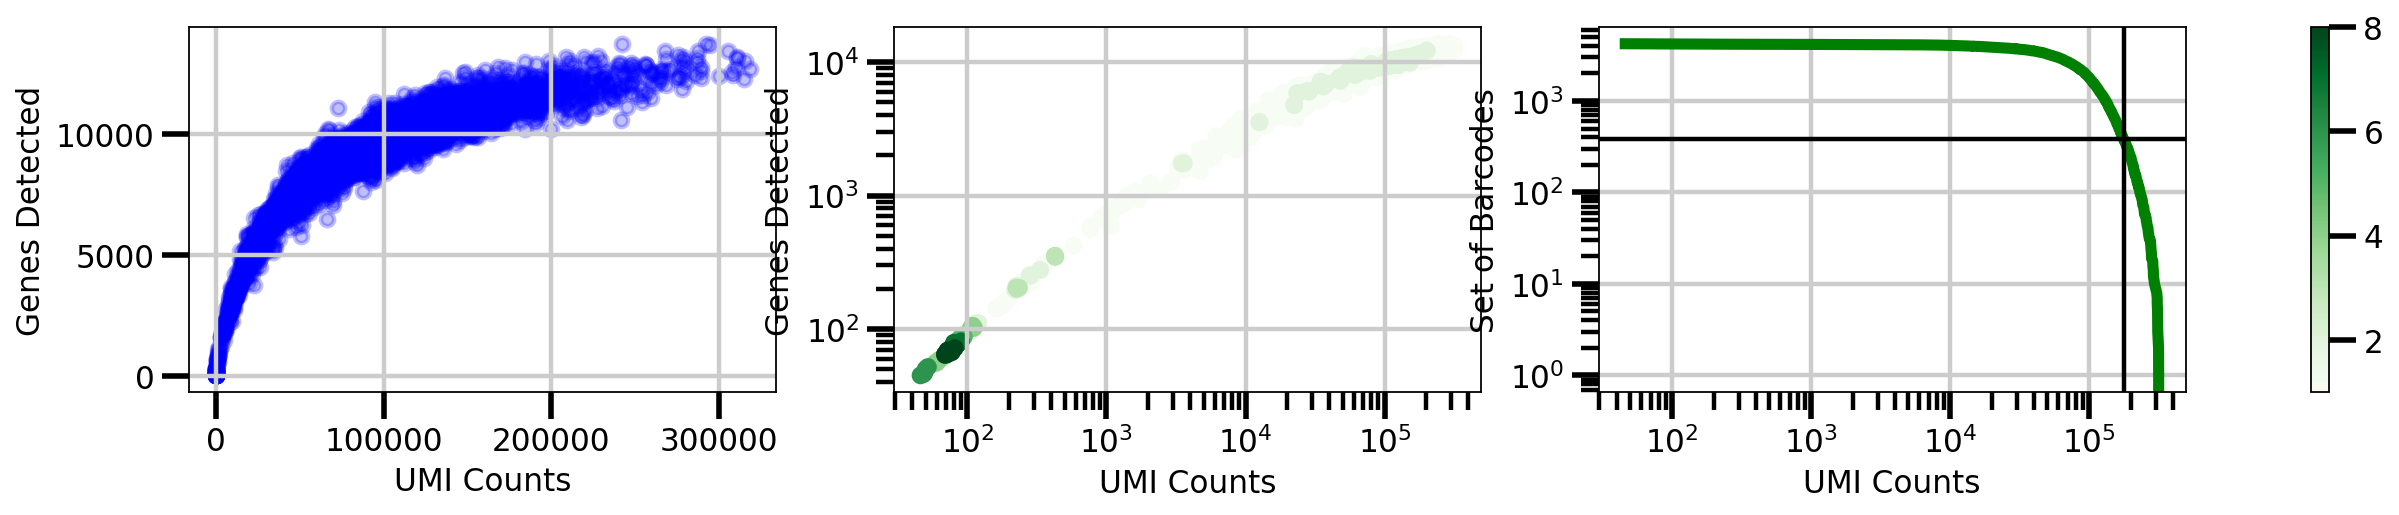

In [27]:
#### RECREATE PLOTS THAT ARE GIVEN IN THE REPORT BY SCILAB!

#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))
y = np.asarray(np.sum(adata.X>0, axis=1))
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
# fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

normalizing counts per cell
    finished (0:00:00)


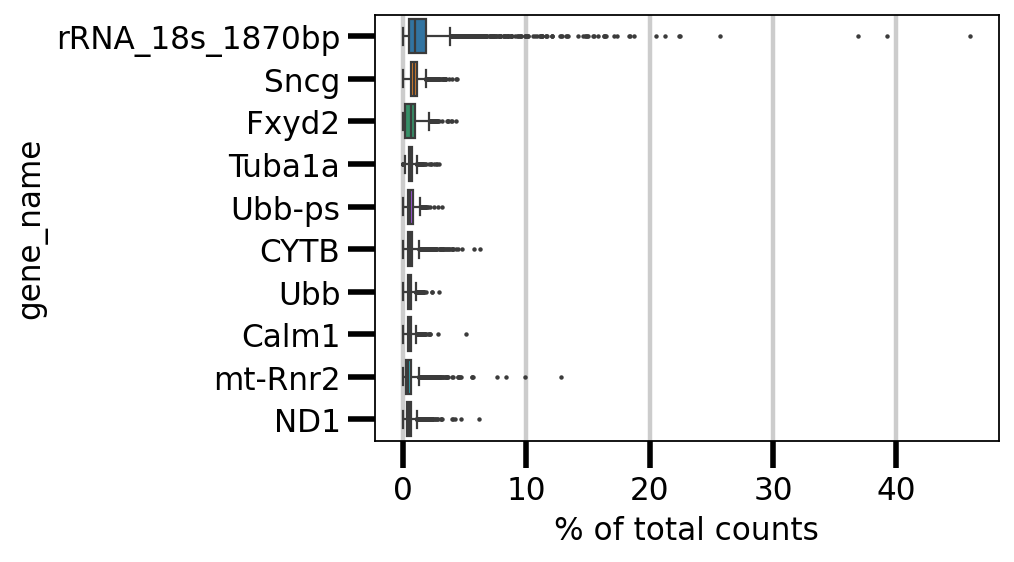

In [28]:
sc.pl.highest_expr_genes(adata, n_top=10, )

In [29]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = MIN_CELL_COUNTS)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Total number of cells before: 4224
filtered out 174 cells that have less than 10000 counts
Total number of cells after: 4050


In [30]:
print('Number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = MIN_GENES)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 4050
filtered out 4 cells that have less than 3000 genes expressed
Total number of cells after: 4046


In [31]:
print('Number of genes before: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_WITH_GENE)
print('Number of genes after: {:d}'.format(adata.n_vars))

Number of genes before: 35546
filtered out 6500 genes that are detected in less than 5 cells
Number of genes after: 29046


In [32]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

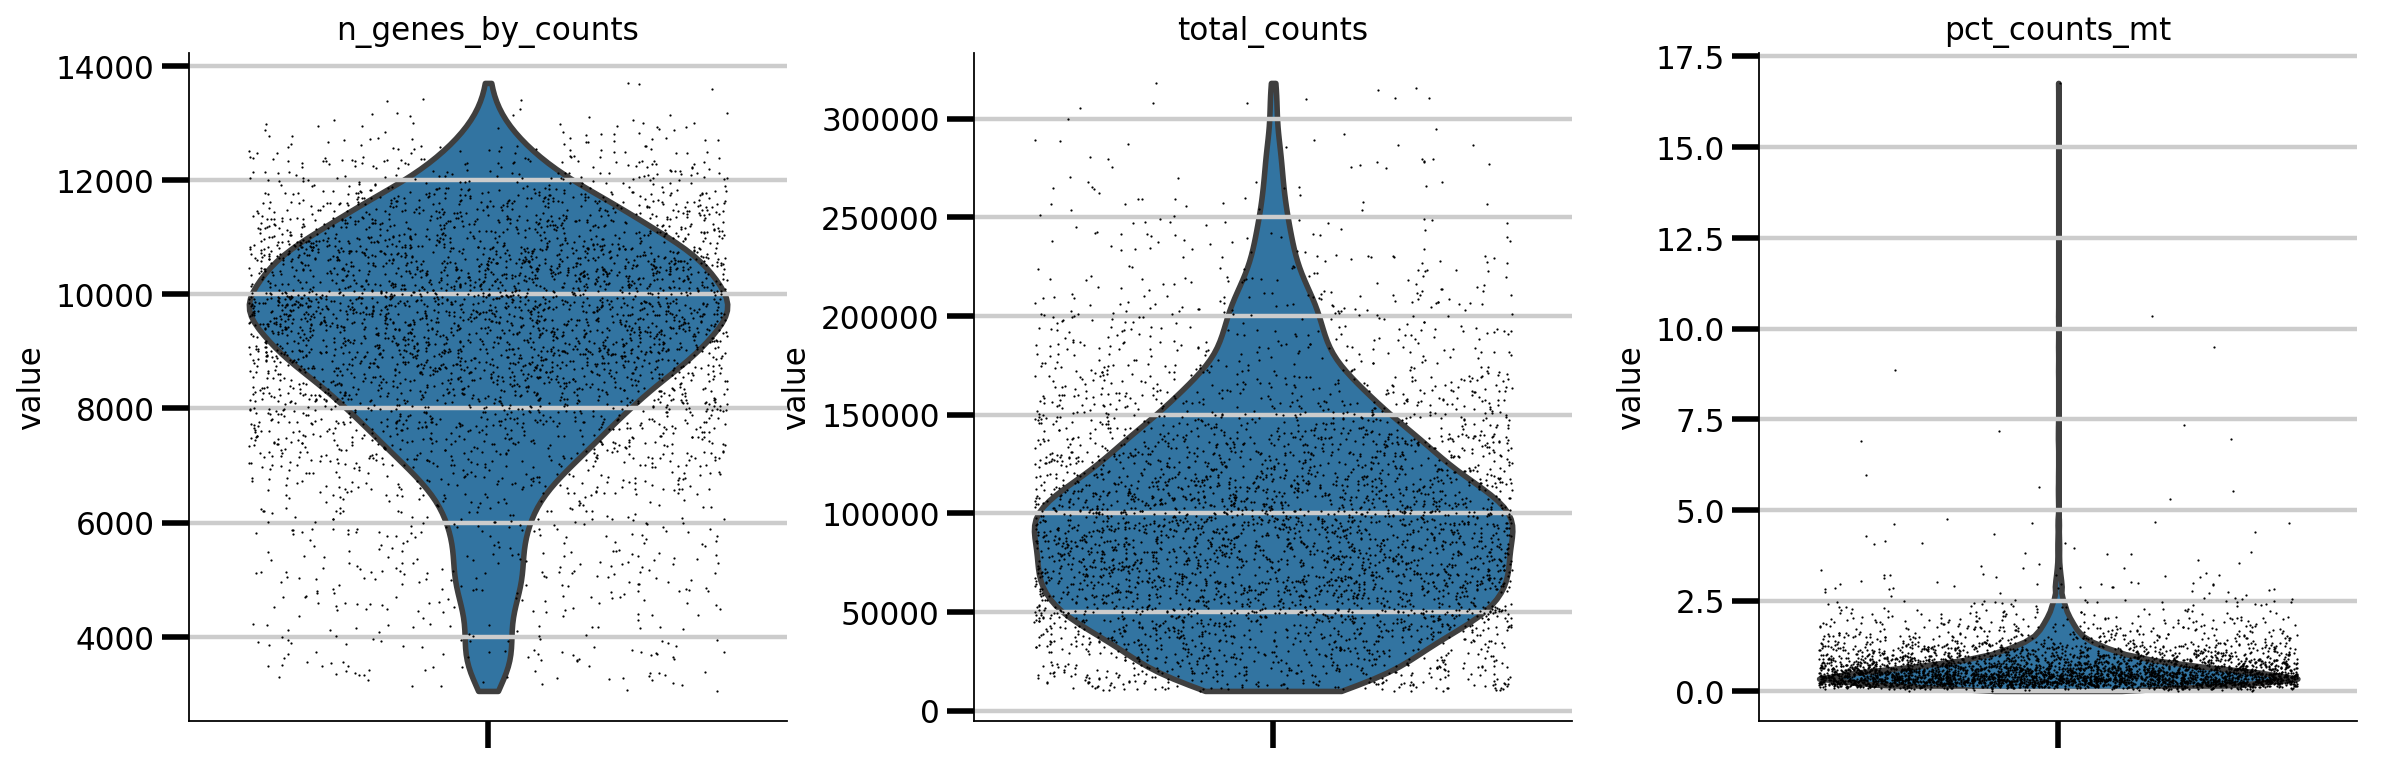

In [33]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [34]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
adata = adata[adata.obs.pct_counts_mt < MITOCHONDRIAL_THRESHOLD_PCT, :]
print('Number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 4046
Number of cells after: 4034


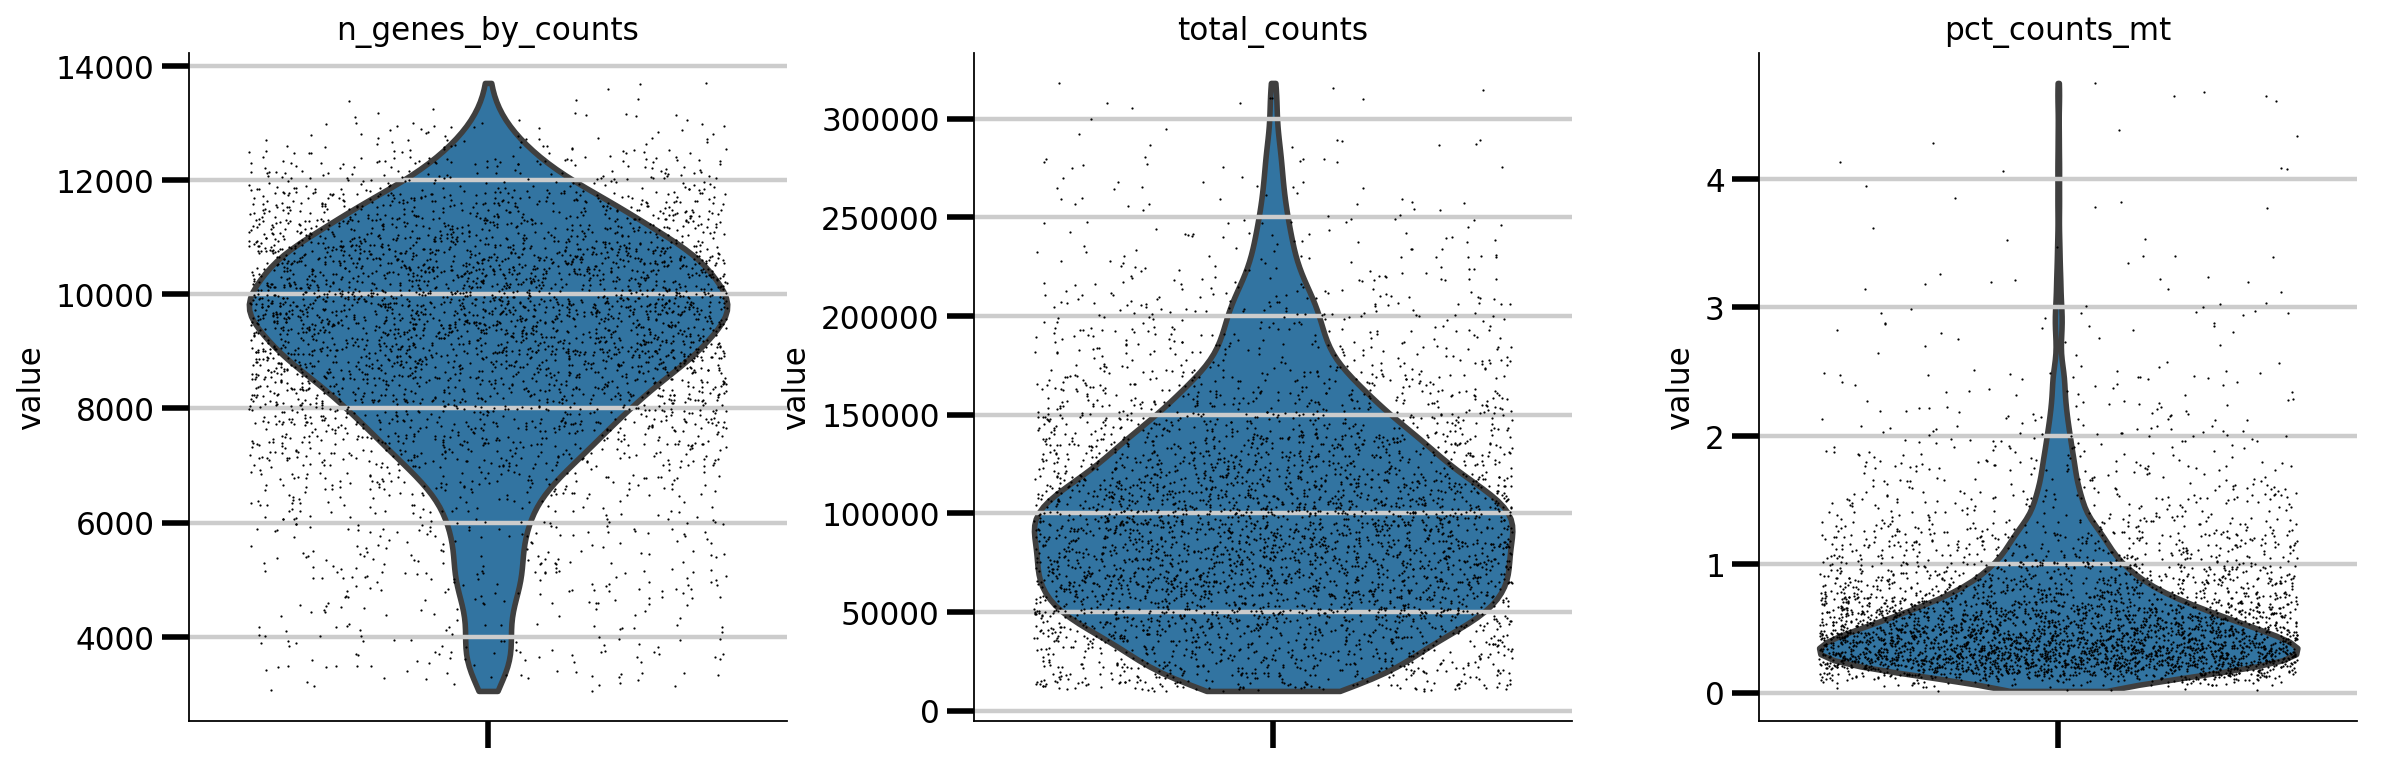

In [35]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [36]:
# save all genes before filtering highly variable
adata.write_h5ad(
    os.path.join(output_path, campari_file_all_genes),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
) 

In [37]:
genes_we_care = ['CT010467.1', 'AY036118', 'Erf1','Gm42418','TdTomato','Cre','Campari','rRNA_18s_1870bp','EGFP','mNeptune','ReachR','flp0','iCre'] 

total_counts = np.sum(adata.var['total_counts'])
print(total_counts)
for gene in genes_we_care:
    count = 0
    for i in range(adata.shape[1]):
        if adata.var['gene_id'][i] == gene:
            print(gene + '_ ' + str((adata.var['total_counts'][count]/total_counts)*100))
        count = count+1

print(adata1.shape)

401731649.0
AY036118_ 0.0008107402063311172
TdTomato_ 0.0003435128906161934
Cre_ 0.005641576922409715
Campari_ 0.04709586622586462
rRNA_18s_1870bp_ 1.387169274283391
EGFP_ 0.0013603608313170268
ReachR_ 0.0012831948921206355
flp0_ 0.0002835225959506118
iCre_ 6.223059612612199e-06
(384, 35546)


In [38]:
# Normalize 
# Seurat tutorial uses: LogNormalize: 
# Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. 
# This is then natural-log transformed using log1p
sc.pp.normalize_total(adata, target_sum=1e4) # + SCtransform???? after normalization and log or instead? does regression as well

normalizing counts per cell
    finished (0:00:00)


In [39]:
# Logarithmize the data
sc.pp.log1p(adata)

In [40]:
# save all genes before filtering highly variable but normed
adata.write_h5ad(
    os.path.join(output_path, campari_file_all_genes_normed),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
) 

In [41]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 16000


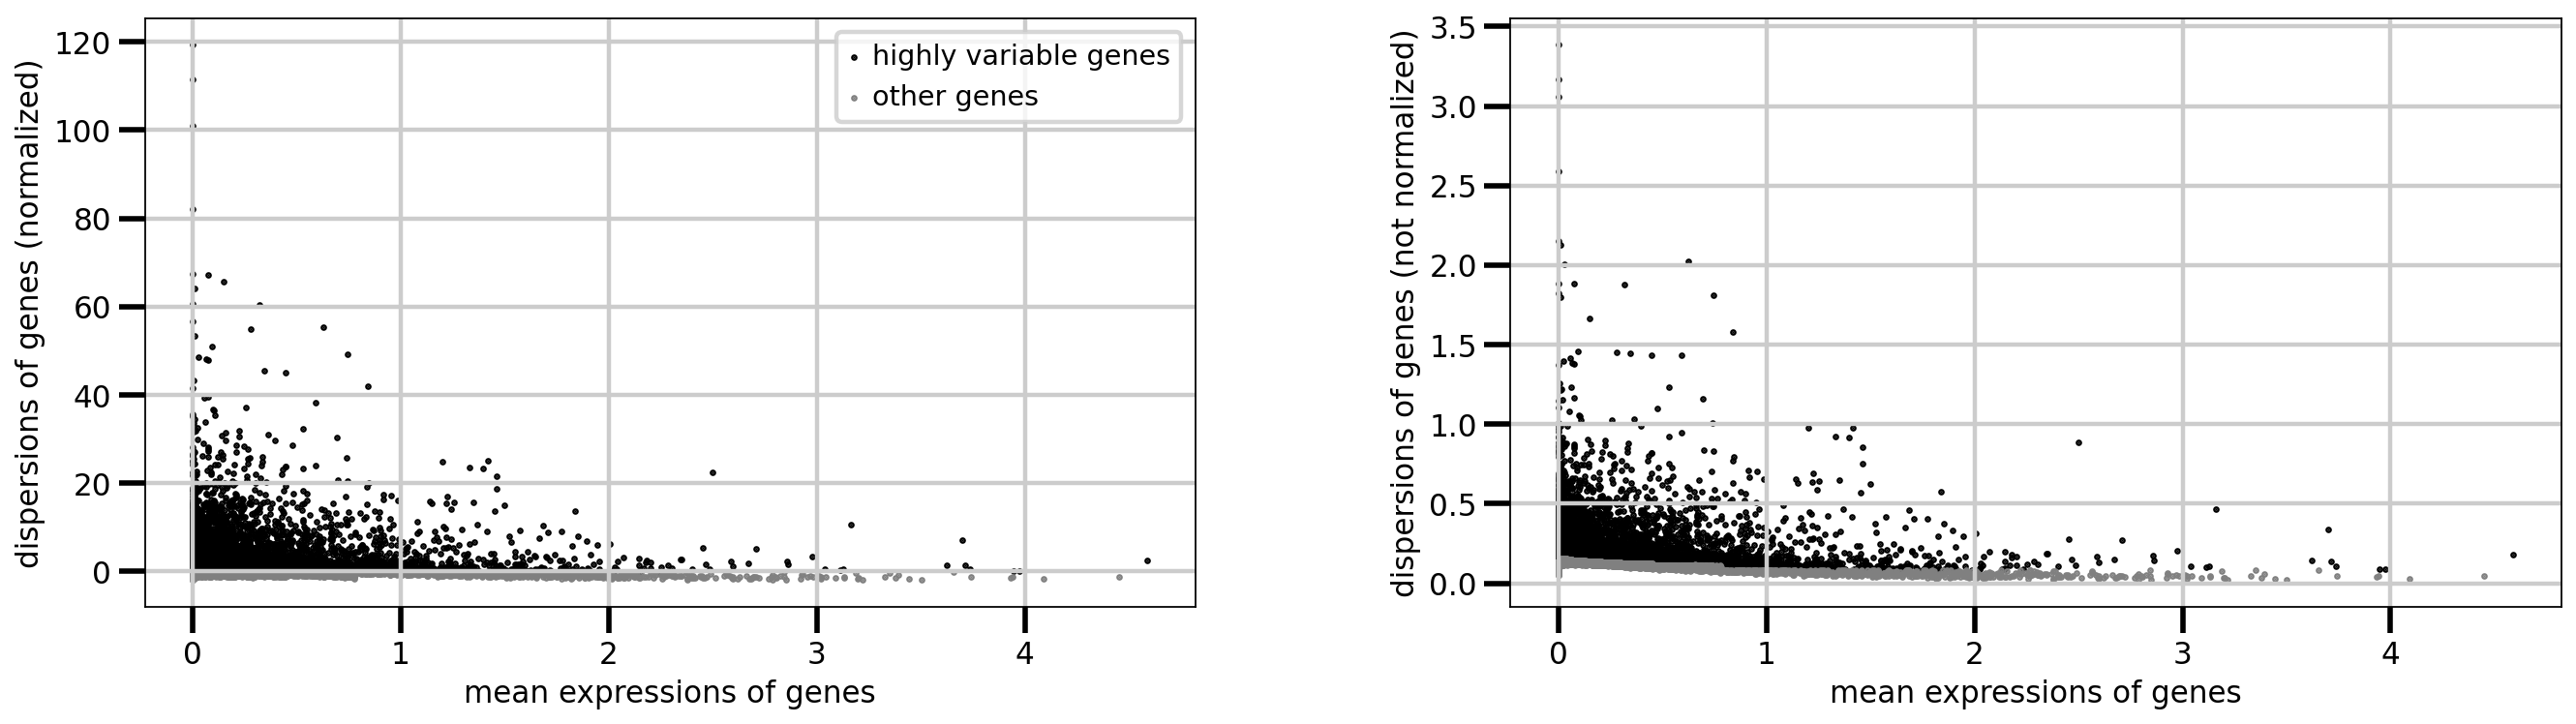

(4034, 29046)


In [42]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

In [43]:
'Piezo1' in adata.var['gene_name'] # check if Piezo1 is still there I have been travelling. Next week I am teaching Mon-Wed, but  anytime on Thursday or Friday should be fine with me.


True

(4034, 16000)


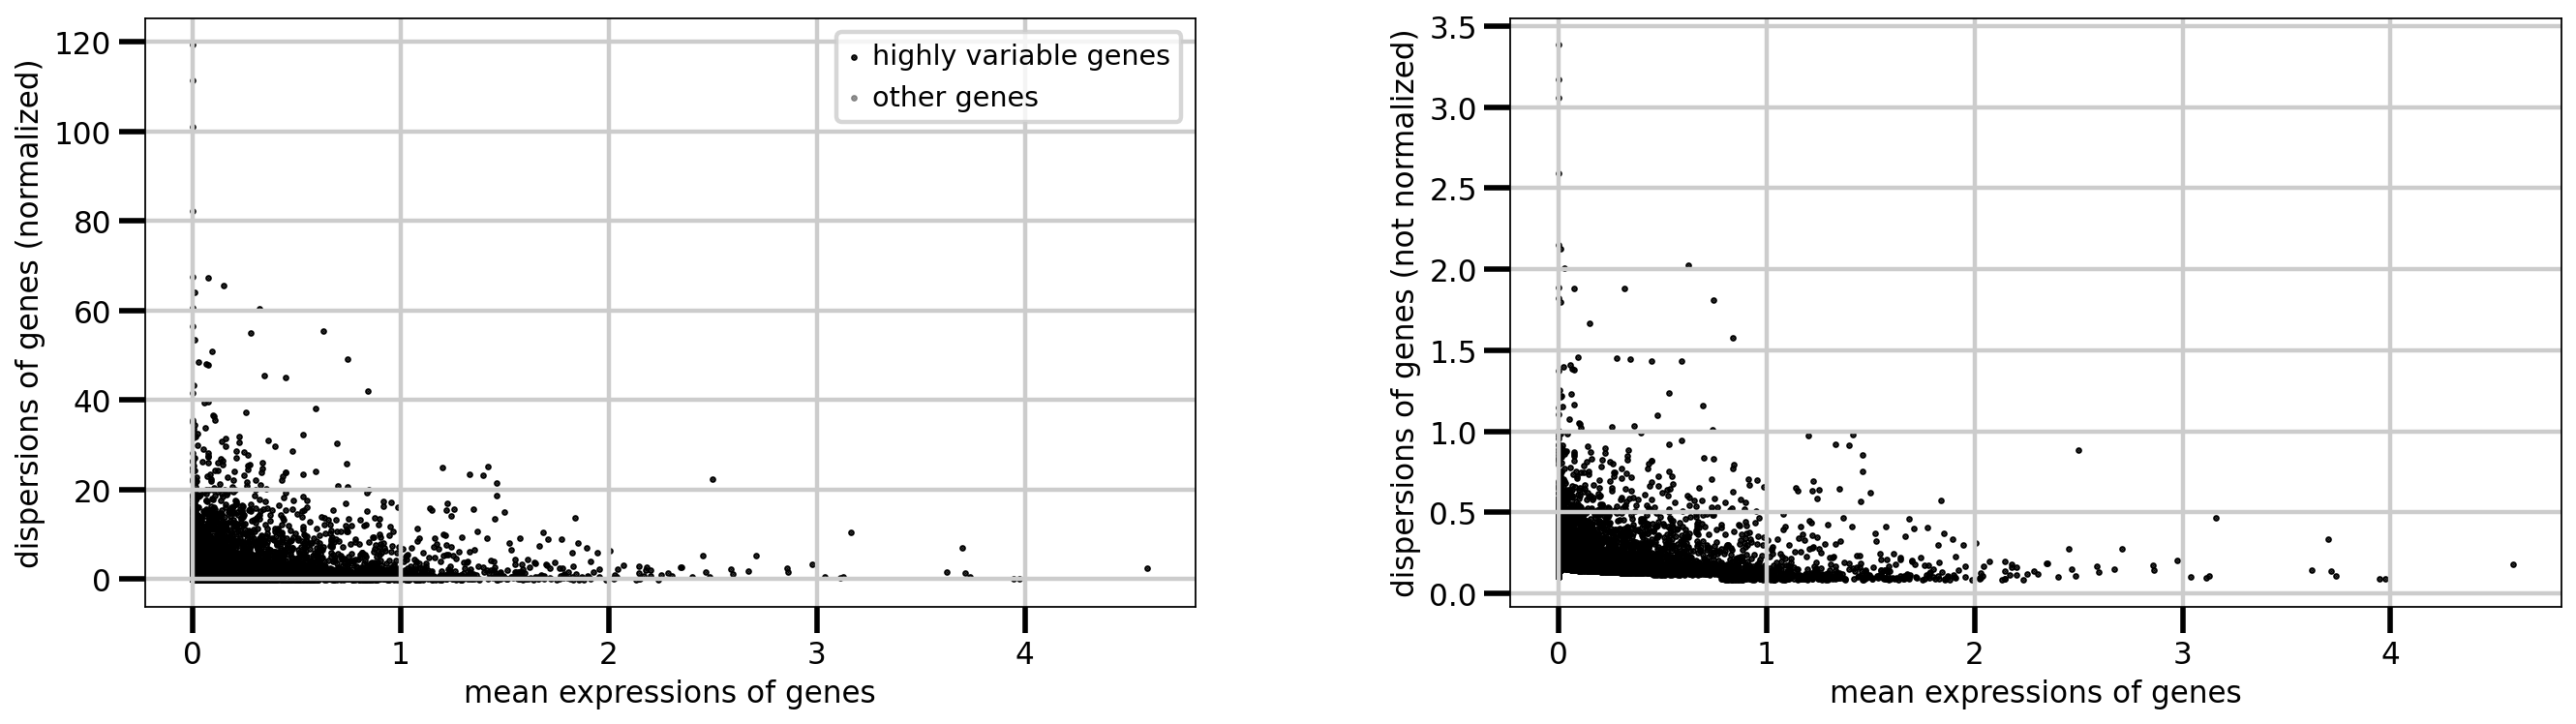

In [44]:
adata = adata[:, adata.var.highly_variable] # keep only highly varialble genes
print(adata.shape)
sc.pl.highly_variable_genes(adata)

In [45]:
'Syn1' in adata.var['gene_name'] # check if Piezo1 is still there

True

In [46]:
# You can get back an AnnData of the object in .raw by calling .raw.to_adata()
# If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all
adata.raw = adata

In [47]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # sometimes can be skipped
sc.pp.scale(adata, max_value=10) # have the numbers around zero

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:23)


In [48]:
# export normalized data
adata.write_h5ad(
    os.path.join(output_path,campari_file),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [49]:
adata.shape

(4034, 16000)